In [1]:
# For every column in the dataset, create a histogram of the values

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.colors import LogNorm

# Import the local utils.py file
import sys
sys.path.append(os.path.join(os.getcwd(), '../'))
from utils import load_config
from analysis_utils import key_histogram, dark_viridis, searchc
from preprocessing.preprocessing_utils import build_df

config = load_config()
sys.path.append(config['PATH_MISC'])
from misc import gpartconv1d

In [3]:
df = build_df()
sqrt_N = int(np.sqrt(len(df)))
crt_N = int(np.power(len(df), 1/3))

In [4]:
# Filter out all columns that only contain less than interesting_threshold distinct values
interesting_threshold = 1
print(f'Removing {np.sum(df.nunique() <= interesting_threshold)} columns with less than {interesting_threshold} distinct values')
df = df.loc[:, df.nunique() > interesting_threshold]

Removing 46 columns with less than 1 distinct values


In [5]:
n_columns = len(df.columns)

# Find the factors a and b of n_columns that are closest to sqrt(n_columns) such that a * b = n_columns
a = int(np.sqrt(n_columns))
b = int(n_columns / a)
r = n_columns - a * b

COLS, ROWS = max(a, b), min(a, b)

print(f'Rows: {ROWS}, Cols: {COLS}, Rem: {r}')

Rows: 13, Cols: 13, Rem: 6


100%|██████████| 175/175 [00:05<00:00, 29.54it/s]


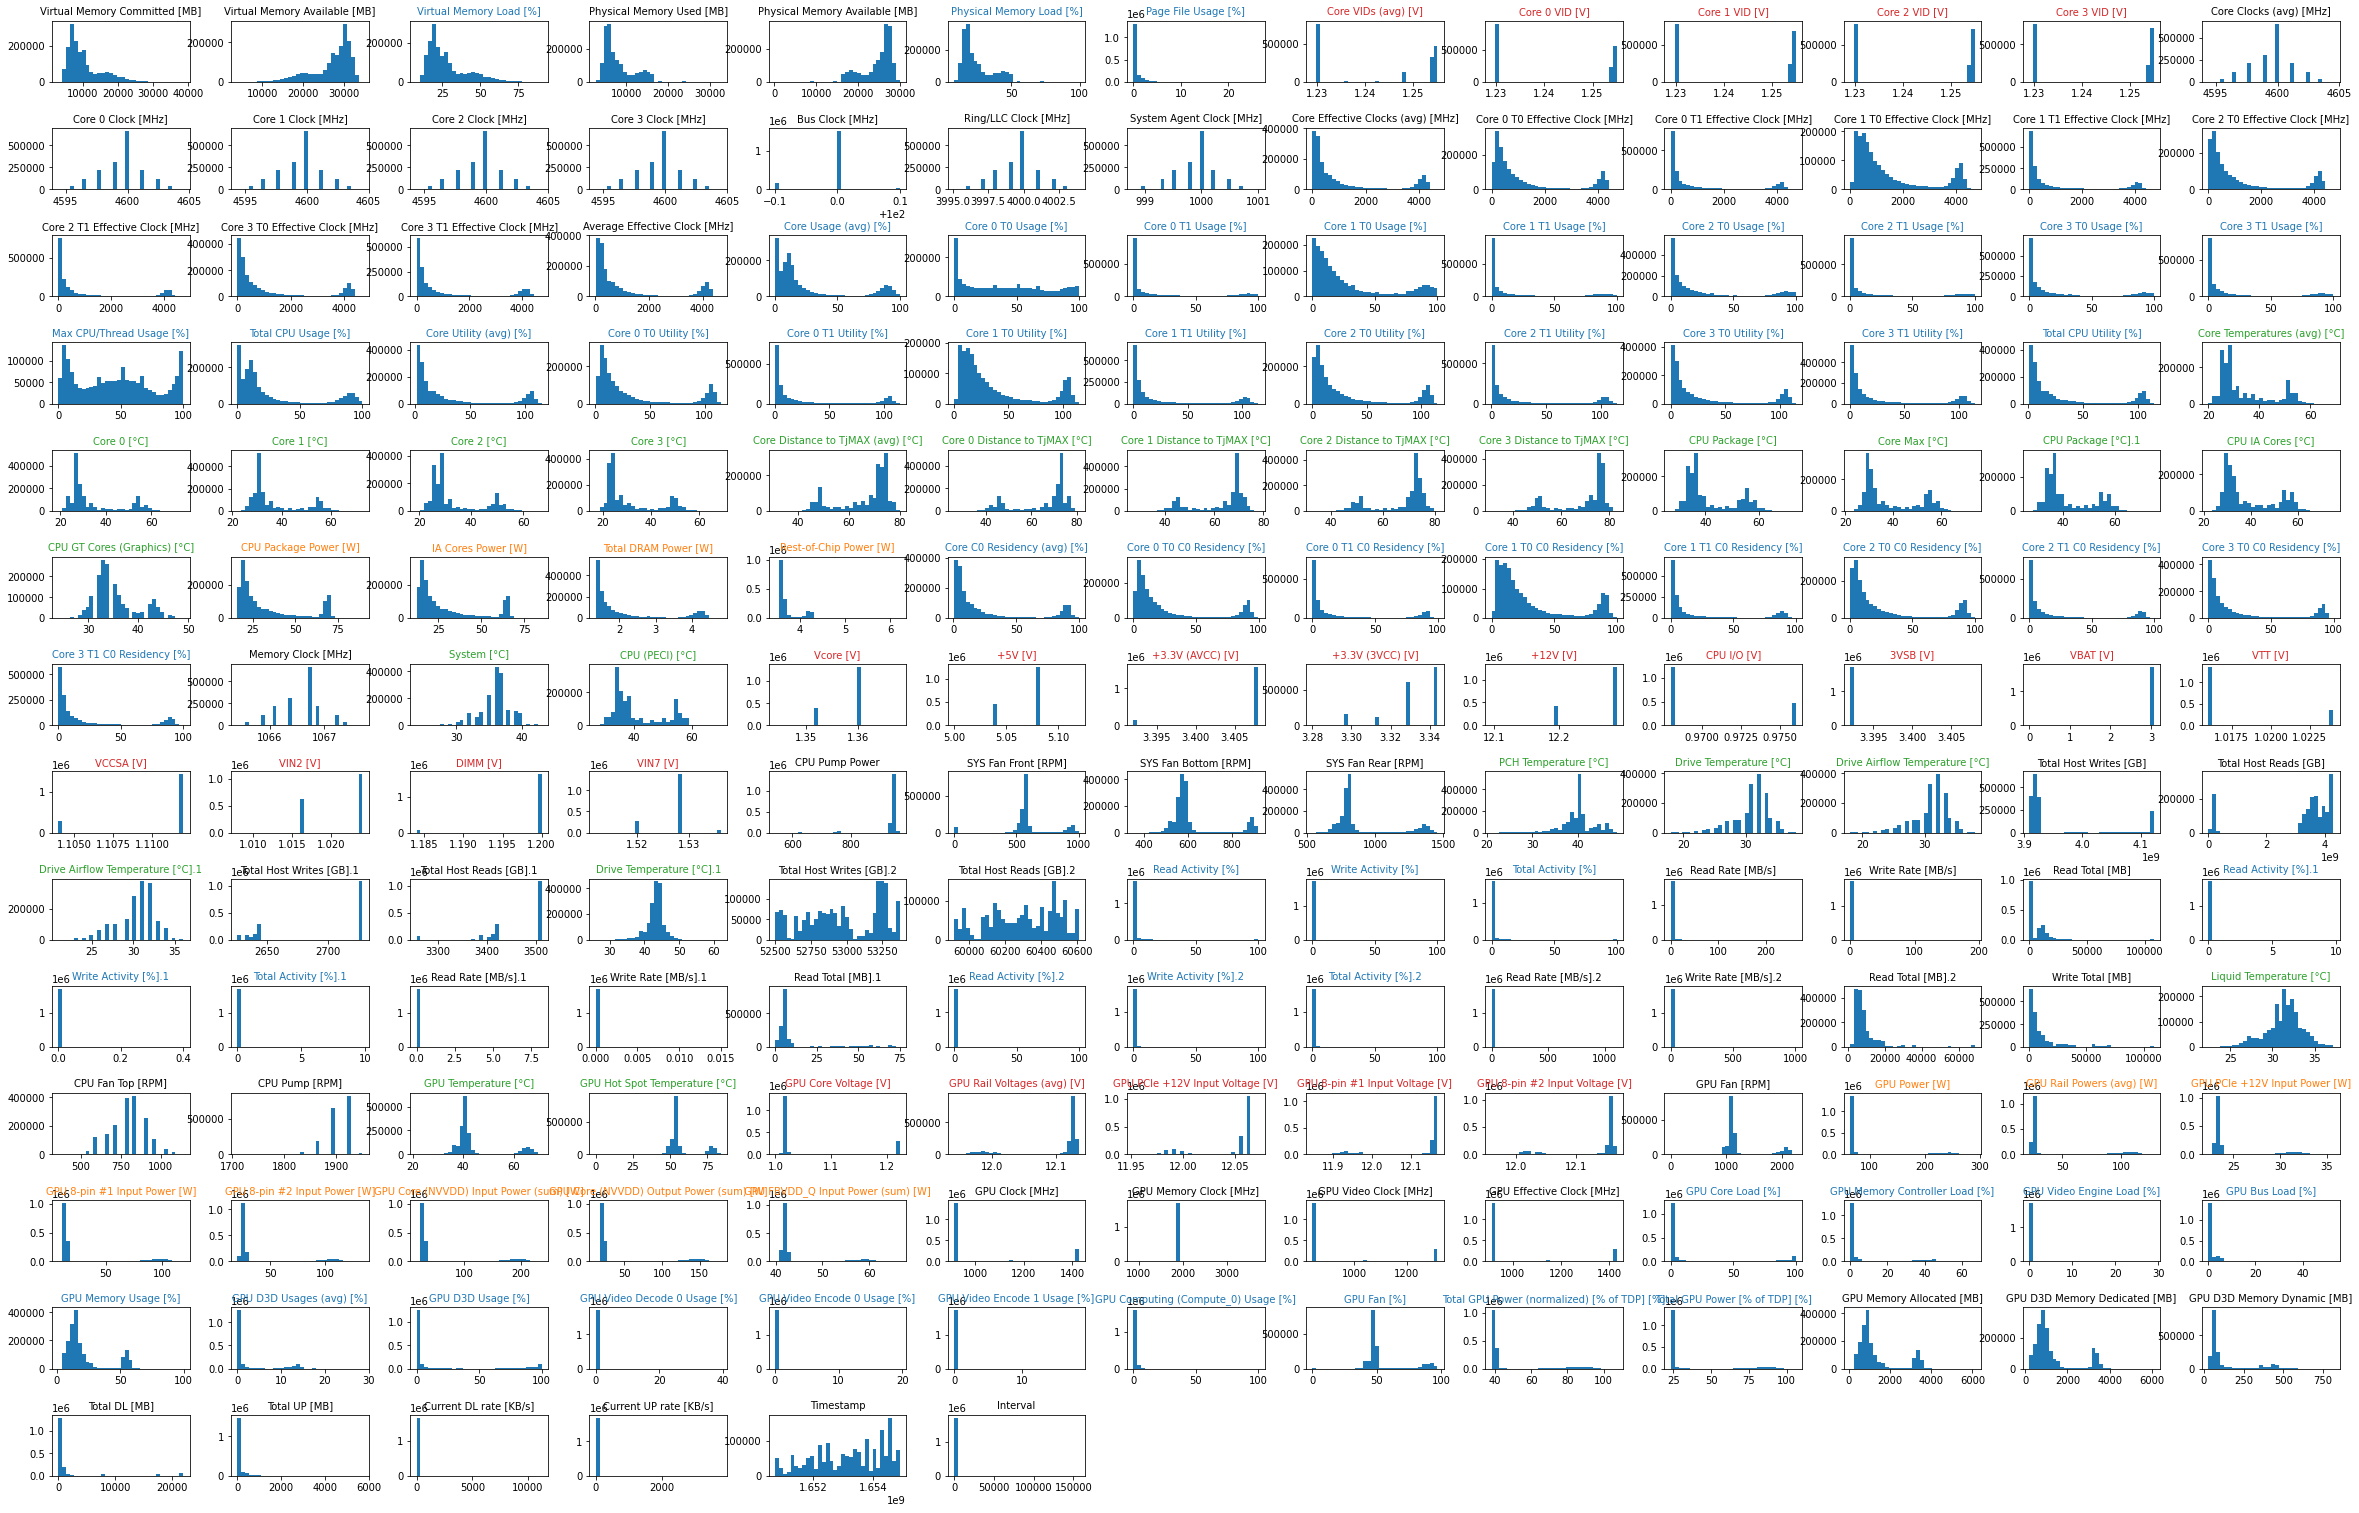

In [6]:
fig, axes = plt.subplots(ROWS + int(r > 0), COLS, figsize=(ROWS*2.5, COLS*1.6))
fig.tight_layout(h_pad=2.5)

# For each column in the dataset, create a histogram
for i, (column_name, ax) in enumerate(zip(tqdm(df.columns), axes.flat)):
    # Get the column values
    col_values = df[column_name]
    # Create the histogram
    ax.hist(col_values, bins=32)

    # Set the title
    # Color the title according to the units they represent
    color_dict = {
        '[%]': 'tab:blue',
        '[W]': 'tab:orange',
        '[°C]': 'tab:green',
        '[V]': 'tab:red'
    }
    color = 'black'
    for key in color_dict:
        if key in column_name:
            color = color_dict[key]
    ax.set_title(column_name, fontsize=10, color=color)

# Hide the remaining axes
for ax in axes.flat[n_columns:]:
    ax.axis('off')

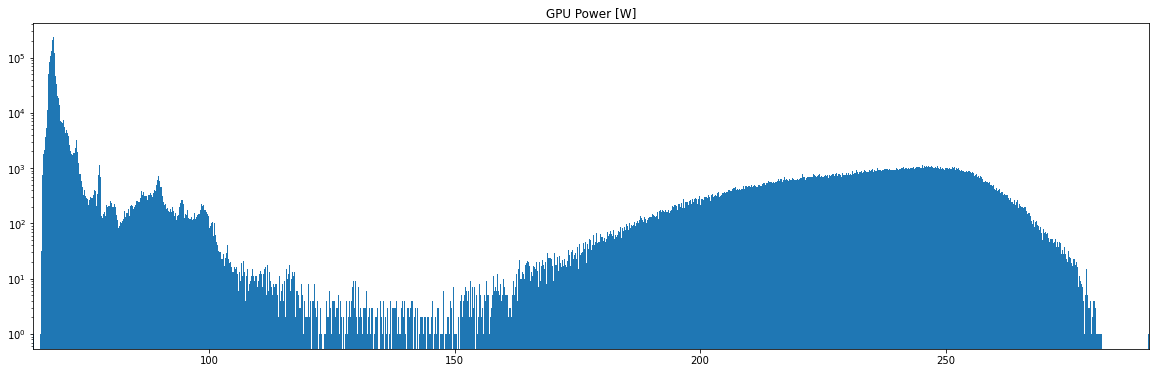

In [7]:
# Plot a detailed histogram of the GPU Power draw
key_histogram(df, key='GPU Power [W]', bins=sqrt_N, figsize=(20, 6), log=True);

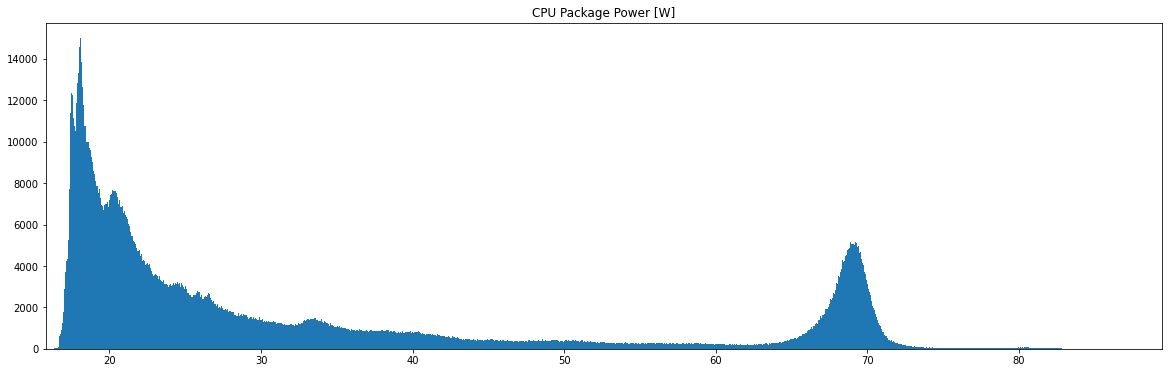

In [8]:
# Plot a detailed histogram of the CPU package power
key_histogram(df, key='CPU Package Power [W]', bins=sqrt_N, figsize=(20, 6), log=False);

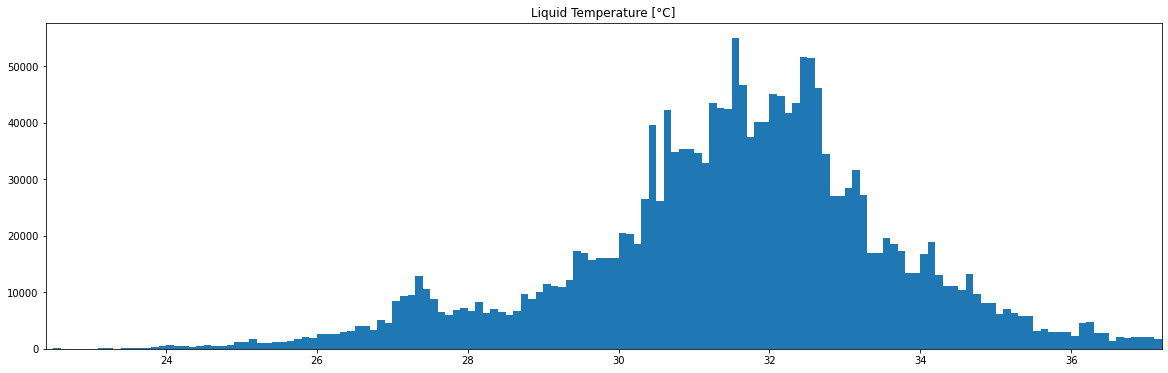

In [9]:
# Plot a detailed histogram of the Liquid Temperature
key_histogram(df, key='Liquid Temperature [°C]', bins=np.unique(df['Liquid Temperature [°C]']), figsize=(20, 6), log=False);

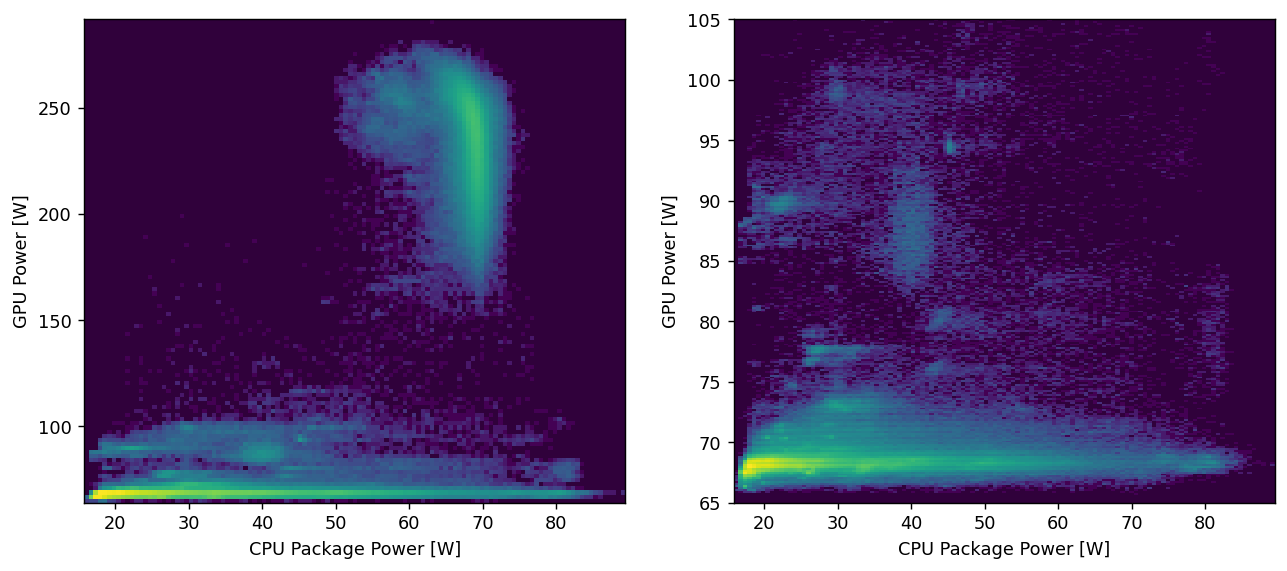

In [10]:
# 2D Histogram of the GPU Power draw and the CPU package power
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=128)
a, b = 'CPU Package Power [W]', 'GPU Power [W]'
axes[0].hist2d(df[a], df[b], bins=crt_N, norm=LogNorm());
axes[1].hist2d(df[a], df[b], bins=(crt_N, np.linspace(65, 105, 250)), norm=LogNorm());
for ax in axes:
    ax.set_facecolor(dark_viridis())
    ax.set_xlabel(a)
    ax.set_ylabel(b);

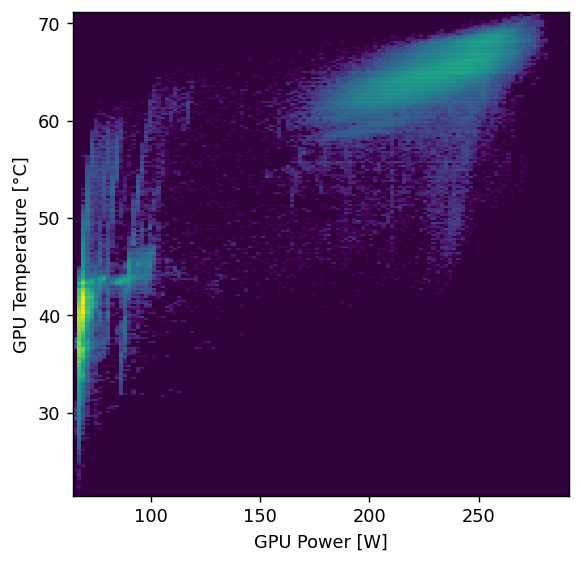

In [11]:
# 2D Histogram of the GPU Power draw and the GPU temperature
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=128)
ax.set_facecolor(dark_viridis())
a, b = 'GPU Power [W]', 'GPU Temperature [°C]'
ax.hist2d(df[a], df[b], bins=(crt_N, int(0.5*len(np.unique(df[b])))), norm=LogNorm());
ax.set_xlabel(a)
ax.set_ylabel(b);

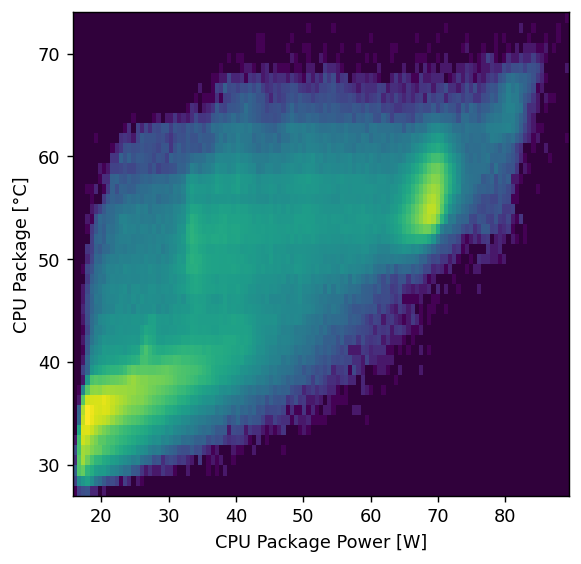

In [12]:
# 2D Histogram of the CPU Power draw and the CPU temperature
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=128)
ax.set_facecolor(dark_viridis())
a, b = 'CPU Package Power [W]', 'CPU Package [°C]'
ax.hist2d(df[a], df[b], bins=(crt_N, int(len(np.unique(df[b])))), norm=LogNorm());
ax.set_xlabel(a)
ax.set_ylabel(b);

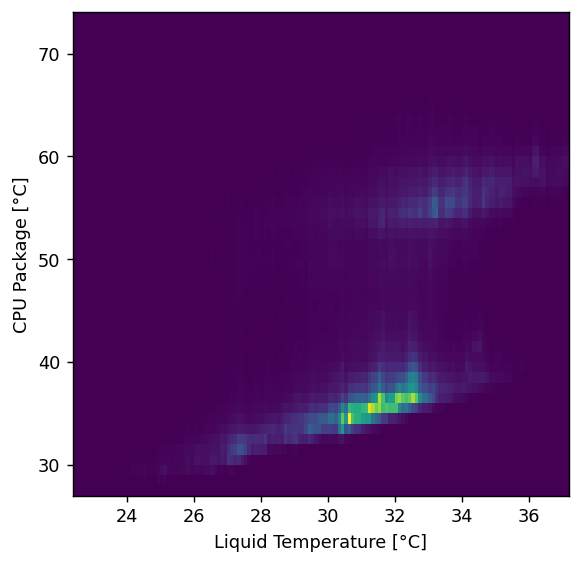

In [13]:
# 2D Histogram of the Liquid temperature and the CPU temperature
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=128)
ax.set_facecolor(dark_viridis())
a, b = 'Liquid Temperature [°C]', 'CPU Package [°C]'
ax.hist2d(df[a], df[b], bins=(np.unique(df[a]), np.unique(df[b])));
ax.set_xlabel(a)
ax.set_ylabel(b);

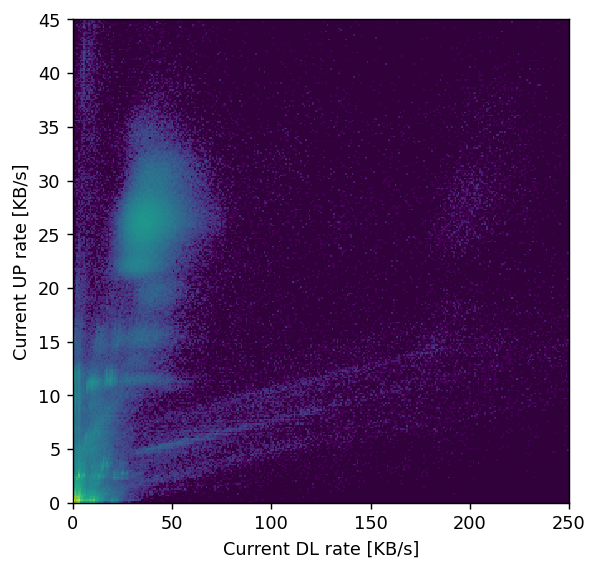

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=128)
ax.set_facecolor(dark_viridis())
a, b = 'Current DL rate [KB/s]', 'Current UP rate [KB/s]'
non_zero_mask = np.logical_and(df[a] > 0, df[b] > 0)
ax.hist2d(df[a][non_zero_mask], df[b][non_zero_mask], bins=(np.linspace(0, 250, 300), np.linspace(0, 45, 300)), norm=LogNorm());
ax.set_xlabel(a)
ax.set_ylabel(b);

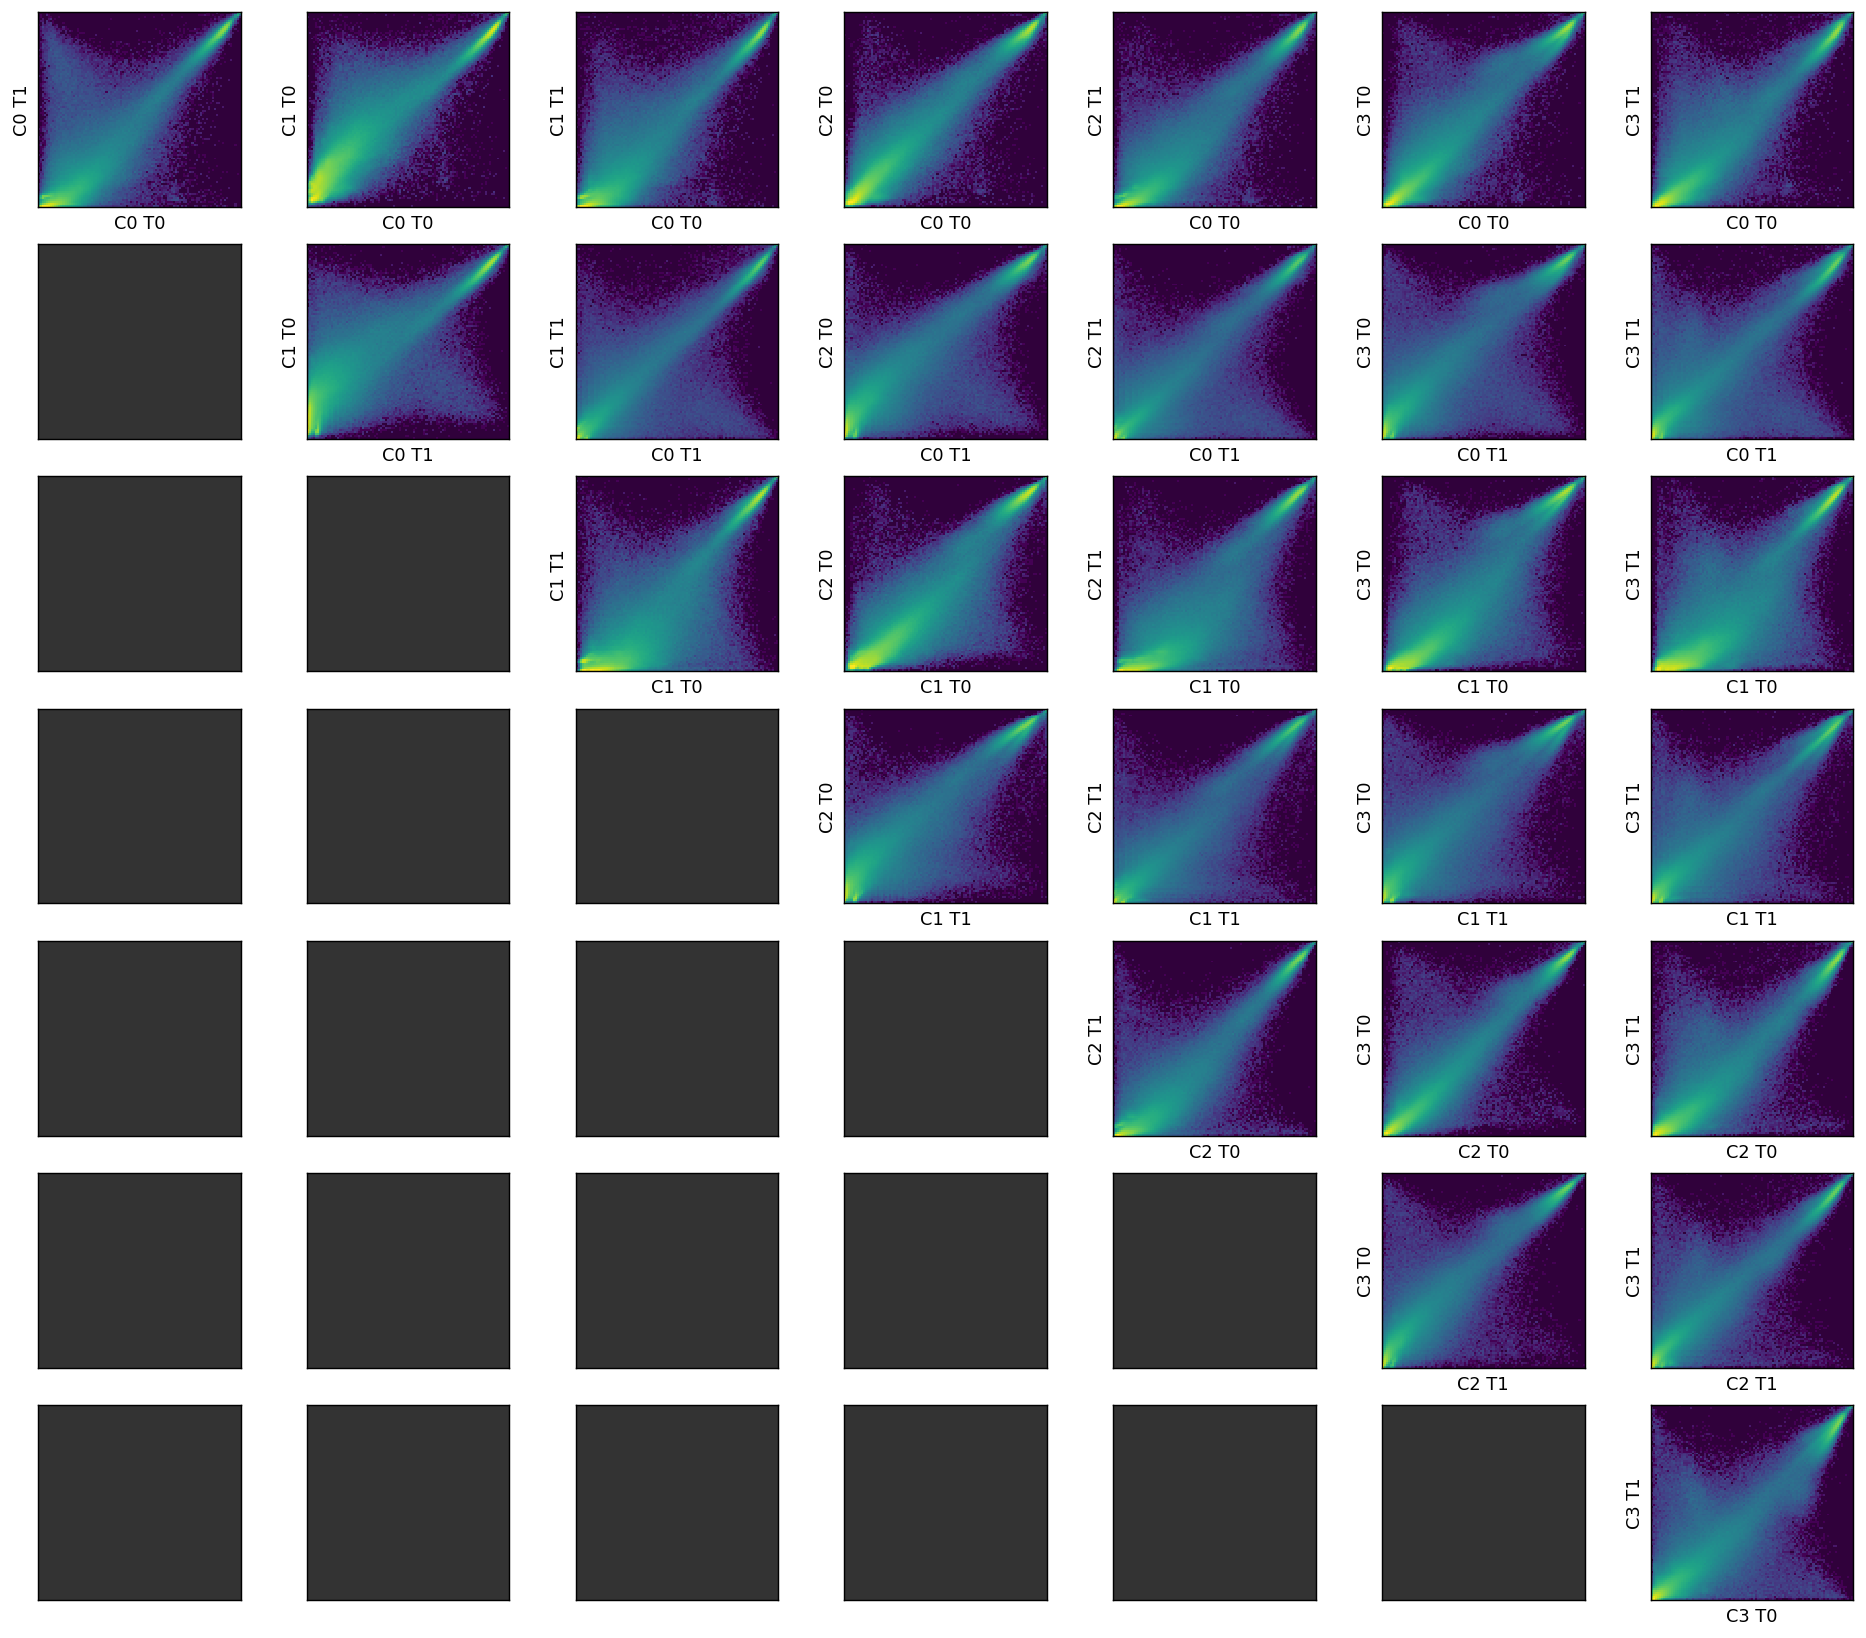

In [15]:
fig, axes = plt.subplots(7, 7, figsize=(15, 13), dpi=128)
fig.tight_layout(h_pad=0, w_pad=0)
fig.set_facecolor('white')

for i in range(7):
    for j in range(i, 7):
        ax = axes[i, j]
        ax.set_facecolor(dark_viridis())
        cx, tx = (i)//2, (i)%2
        cy, ty = (j+1)//2, (j+1)%2
        a, b = f'Core {cx} T{tx} Effective Clock [MHz]', f'Core {cy} T{ty} Effective Clock [MHz]'
        non_zero_mask = np.logical_and(df[a] > 0, df[b] > 0)
        ax.hist2d(df[a][non_zero_mask], df[b][non_zero_mask], bins=(np.linspace(0, 4600, 100), np.linspace(0, 4600, 100)), norm=LogNorm());
        ax.set_xlabel(f'C{cx} T{tx}'); ax.set_ylabel(f'C{cy} T{ty}');
        ax.set_xticks([]); ax.set_yticks([]);

# Cover the remaining axes
for i in range(7):
    for j in range(i):
        axes[i, j].set_facecolor('#333333')
        axes[i, j].set_xticks([]); axes[i, j].set_yticks([]);

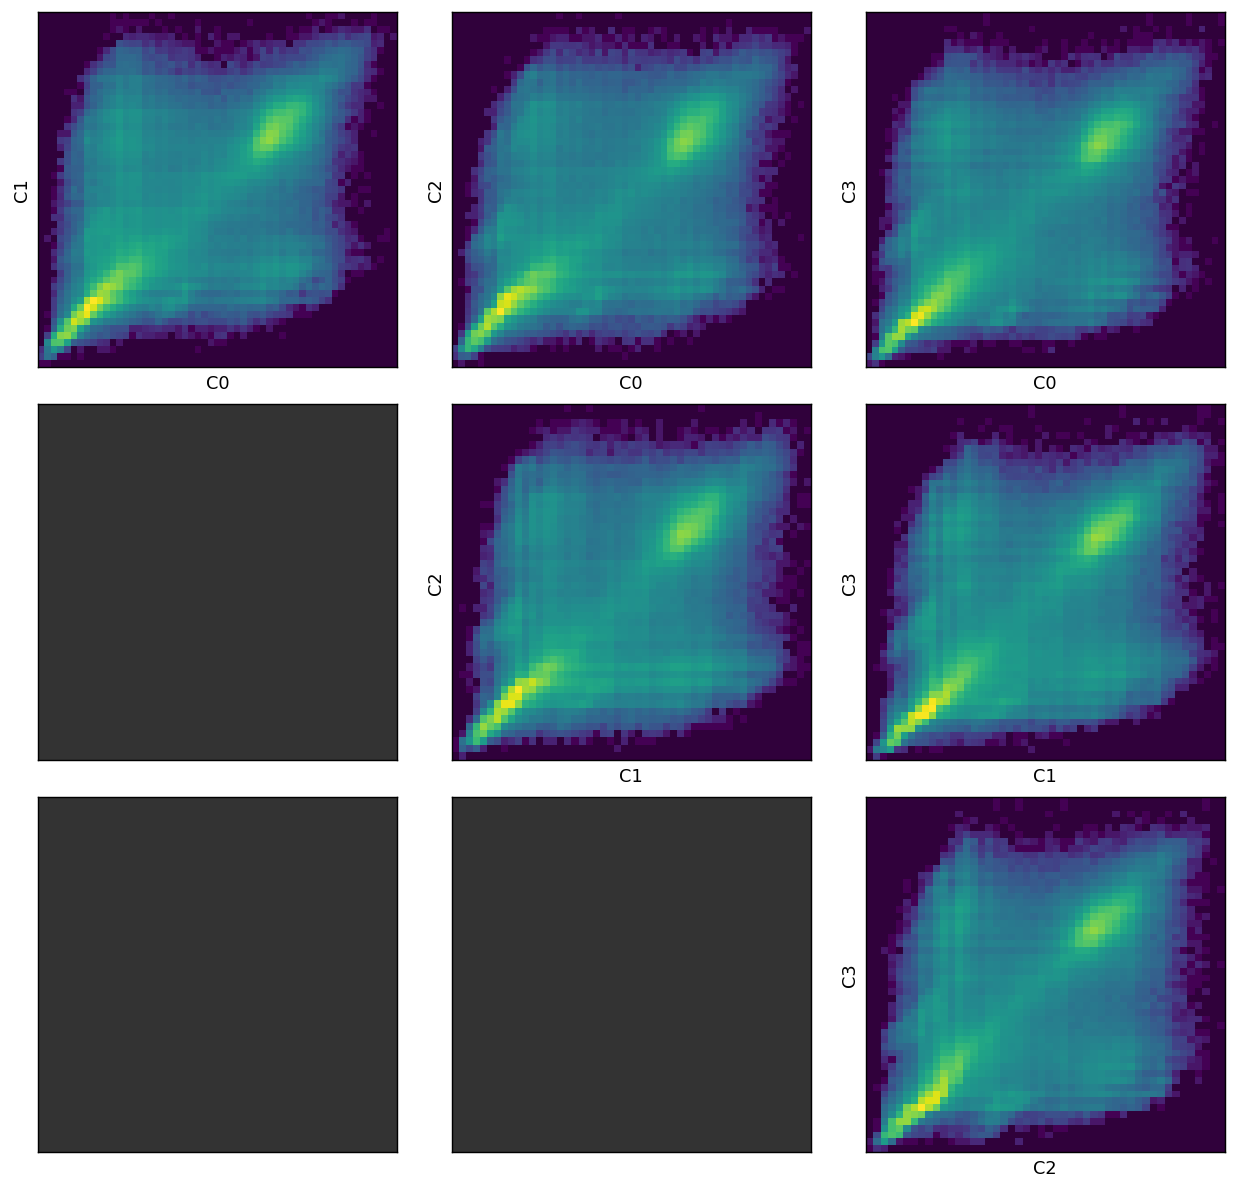

In [16]:
fig, axes = plt.subplots(3, 3, figsize=(10, 9.5), dpi=128)
fig.tight_layout(h_pad=0, w_pad=0)
fig.set_facecolor('white')

for i in range(3):
    for j in range(i, 3):
        ax = axes[i, j]
        ax.set_facecolor(dark_viridis())
        cx = (i)
        cy = (j+1)
        a, b = f'Core {cx} [°C]', f'Core {cy} [°C]'
        non_zero_mask = np.logical_and(df[a] > 0, df[b] > 0)
        ax.hist2d(df[a][non_zero_mask], df[b][non_zero_mask], bins=[np.unique(df[k][non_zero_mask]) for k in [a, b]], norm=LogNorm());
        ax.set_xlabel(f'C{cx}'); ax.set_ylabel(f'C{cy}');
        ax.set_xticks([]); ax.set_yticks([]);

# Cover the remaining axes
for i in range(3):
    for j in range(i):
        axes[i, j].set_facecolor('#333333')
        axes[i, j].set_xticks([]); axes[i, j].set_yticks([]);

In [17]:
sigma = 2*60*0.5

smooth_liquid_temperature_diff = gpartconv1d(np.diff(df['Liquid Temperature [°C]']), sigma=sigma)
smooth_cpu_package_power = gpartconv1d(df['CPU Package Power [W]'][:-1], sigma=sigma)
smooth_cpu_temperature = gpartconv1d(df['CPU Package [°C]'][:-1], sigma=sigma)

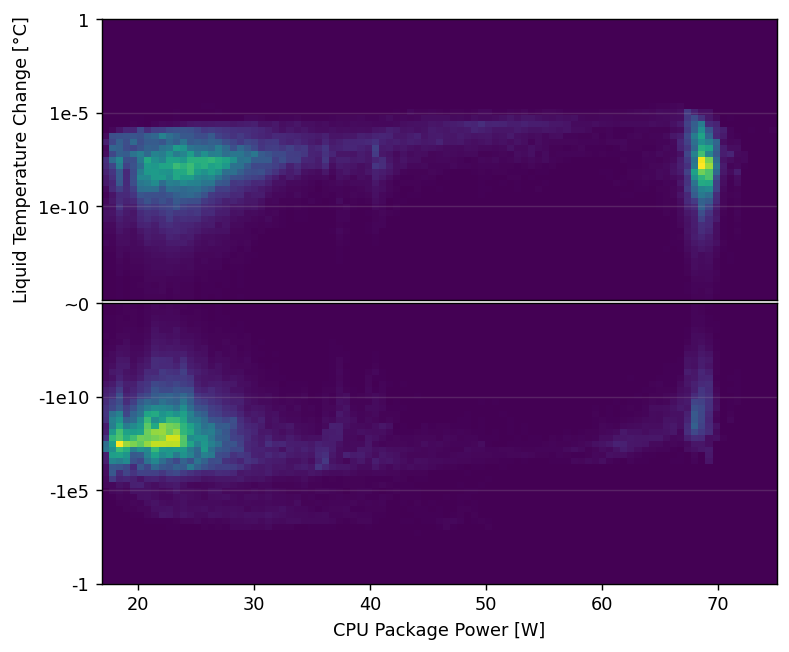

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(6, 5), dpi=128)
fig.tight_layout(h_pad=-1.9)
bins=48

axes[0].hist2d(
    smooth_cpu_package_power[smooth_liquid_temperature_diff>0],
    np.log(smooth_liquid_temperature_diff[smooth_liquid_temperature_diff>0]),
    bins=(np.linspace(min(smooth_cpu_package_power),
        max(smooth_cpu_package_power), bins*2), np.linspace(-15, 0, bins)));
axes[1].hist2d(
    smooth_cpu_package_power[smooth_liquid_temperature_diff<0],
    -np.log(-smooth_liquid_temperature_diff[smooth_liquid_temperature_diff<0]),
    bins=(np.linspace(min(smooth_cpu_package_power),
        max(smooth_cpu_package_power), bins*2), np.linspace(0, 15, bins)));

axes[0].set_yticks([-10, -5, 0]); axes[0].set_yticklabels(['1e-10', '1e-5', '1']);
axes[1].set_yticks([0, 5, 10, 15]); axes[1].set_yticklabels(['-1', '-1e5', '-1e10', '~0']);
axes[0].set_xticks([])
axes[1].set_xlabel('CPU Package Power [W]'); axes[0].set_ylabel('Liquid Temperature Change [°C]');
axes[0].grid(axis='y', alpha=0.2); axes[1].grid(axis='y', alpha=0.2);